In [9]:
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from NegativeClassOptimization import config, ml, preprocessing, datasets, utils, visualisations
from utils_07 import get_attr_from_records, get_onehotstack_from_records



In [10]:
task_types = (
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

def create_task(task_type, ag):
    task = datasets.ClassificationTask(
        task_type=task_type,
        ag_pos=ag,
        ag_neg="auto",
        seed_id=0,
        split_id=42,
    )
    return task

In [11]:
attributor_name = "DeepLIFT_LOCAL_v2.0-2"
def get_attr_aa(task_attributions):
    attr_stack = get_attr_from_records(
        task_attributions, attributor_name, (0, 1)  # type: ignore
    )  # Nx11x20
    onehot_stack = get_onehotstack_from_records(
        task_attributions, (0, 1)  # type: ignore
    )  # Nx220
    attr_aa = attr_stack[onehot_stack.reshape((-1, 11, 20)) == 1].reshape(
        -1, 11
    )  # Nx11
    return attr_aa

In [12]:
def get_abundance_array(slide, pwm):
    return np.array([pwm[s][i] for i, s in enumerate(slide)])

In [13]:
from Bio import motifs
from Bio.Seq import Seq

In [17]:
res = []
for ag in config.ANTIGENS:
    for task_type in task_types:
        task = create_task(task_type, ag)
        task_obj = loader.load(task, load_model=False, load_test_dataset=False, load_train_dataset=True,  attributions_toload='v2.0-2',attribution_records_toload="attribution_records.json")
        df_train = task_obj.train_dataset
        df_train = df_train.query("binds_a_pos_ag == 1")
        seqs = df_train.Slide.tolist()
        seqs_as_lists = [Seq(s) for s in seqs]
        m = motifs.create(seqs_as_lists, alphabet=config.AMINOACID_ALPHABET)

        df_attr_test = pd.DataFrame(task_obj.attributions)
        df_attr_test['attr_aa'] = get_attr_aa(task_obj.attributions).tolist()        
        df_attr_test['attr_aa_norm'] = df_attr_test.attr_aa.apply(lambda x: x / np.linalg.norm(x))

        df_attr_test['Slide_by_aa_abund'] = df_attr_test.slide.apply(lambda x: get_abundance_array(x, m.pwm))
        df_attr_test['Slide_by_aa_abund_norm'] = df_attr_test.Slide_by_aa_abund.apply(lambda x: x / np.linalg.norm(x))

        #df_attr_test = df_attr_test.query("y_true == 1")
        x_values = np.concatenate(df_attr_test.attr_aa_norm.to_numpy())
        y_values = np.concatenate(df_attr_test.Slide_by_aa_abund_norm.to_numpy())
        r = np.corrcoef(x_values, y_values)[1,0]

        res.append({
            'antigen': ag,
            'task': task_type.name,
            'correlation': r
})
df_res = pd.DataFrame(res)

In [18]:
palette = {'1FBI': '#008080',
 '3VRL': '#FFA07A',
 '2YPV': '#000080',
 '5E94': '#FFD700',
 '1WEJ': '#228B22',
 '1OB1': '#FF69B4',
 '1NSN': '#800080',
 '1H0D': '#FF6347',
 '3RAJ': '#00FF00',
 '1ADQ': '#FF1493'}

<ipython-input-19-75a49c531d7f>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['vs 9', 'vs Non-binder', 'vs Weak'])


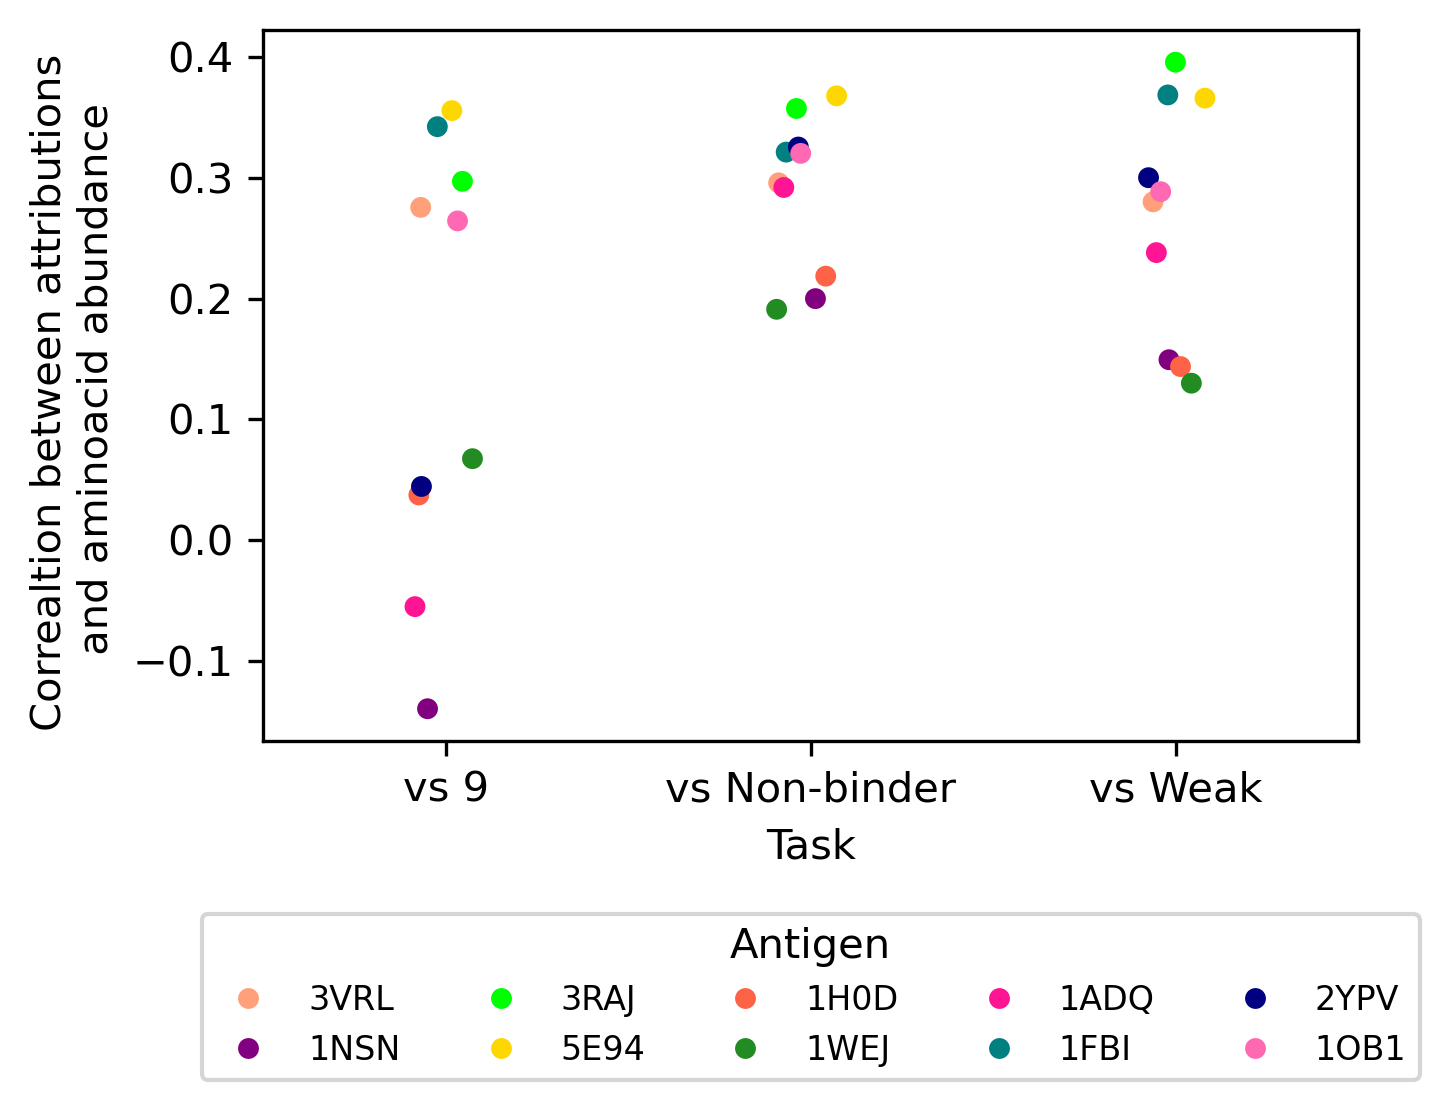

In [19]:
fig, ax = plt.subplots(figsize=(1.5*3.14, 3.14), dpi=300)

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_res, 
    x="task", 
    y="correlation", 
    hue="antigen", 
    ax=ax, 
    palette=palette,
)
ax.set_ylabel('Correaltion between attributions \n and aminoacid abundance')
ax.set_xlabel('Task')
ax.set_xticklabels(['vs 9', 'vs Non-binder', 'vs Weak'])
#legend outside the figure at the bottom
ax.legend(loc='lower center', title='Antigen', ncol=5, bbox_to_anchor=(0.5, -0.5), fontsize=8)


<Axes: >

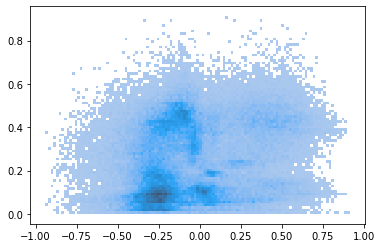

In [64]:
x_values = np.concatenate(df_attr_test.attr_aa_norm.to_numpy())
y_values = np.concatenate(df_attr_test.Slide_by_aa_abund_norm.to_numpy())
sns.histplot(x = x_values, y = y_values)


In [65]:
np.corrcoef(x_values, y_values)[1,0]

0.1991962852475022

In [110]:
df_attr_test

,slide,logits,expits,y_pred,y_true,is_pred_correct,DeepLIFT_LOCAL_v2.0-2,DeepLIFT_GLOBAL_R10_v2.0-2,exec_time,attr_aa,attr_aa_norm,Slide_by_aa_abund,Slide_by_aa_abund_norm
0,LRWLPLFAMDY,11.237535,9.999869e-01,1,1,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-1.0858906507492065, 1.5448909997940063, -3....",17688.854217,"[1.648332953453064, 0.05967997387051582, 0.305...","[0.5661165730118383, 0.020496964654037365, 0.1...","[0.08546666666666666, 0.18726666666666666, 0.0...","[0.13111832771199222, 0.28729437015833553, 0.0..."
1,LEILGLLAMDY,10.966885,9.999827e-01,1,1,True,"[[0.16005393862724304, 0.0, 0.0, 1.04017305374...","[[-1.2183682918548584, 1.1663317680358887, -3....",17688.854217,"[1.7364308834075928, 0.10993901640176773, 0.95...","[0.547139283584465, 0.03464114537861768, 0.300...","[0.08546666666666666, 0.029266666666666667, 0....","[0.13147514690678946, 0.045021520664649435, 0...."
2,AALGLLRFLYF,10.925271,9.999820e-01,1,1,True,"[[-0.7186316251754761, 0.0, 0.0, 0.0, -0.23859...","[[-0.6181144714355469, -0.23213572800159454, -...",17688.854217,"[-0.7186316251754761, -0.18552370369434357, 1....","[-0.24605611075254857, -0.06352244931092718, 0...","[0.18933333333333333, 0.21313333333333334, 0.2...","[0.3003439685949073, 0.3380984745063094, 0.393..."
3,CARIQLRLAWC,10.903599,9.999816e-01,1,1,True,"[[0.2758382558822632, 1.768760323524475, 0.0, ...","[[-2.161139965057373, 2.527822971343994, -7.83...",17688.854217,"[1.768760323524475, -0.834553599357605, -1.500...","[0.255233645153536, -0.1204268065079637, -0.21...","[0.25933333333333336, 0.21313333333333334, 0.1...","[0.5653513812092837, 0.46463454131775833, 0.26..."
4,WSLNFITTVGF,10.822377,9.999801e-01,1,1,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.760973...","[[-2.2209155559539795, 0.05378309637308121, -3...",17688.854217,"[1.189186930656433, -0.3701898455619812, 4.095...","[0.1893306135699427, -0.05893797584785379, 0.6...","[0.031066666666666666, 0.05266666666666667, 0....","[0.10373154903814433, 0.1758539136054378, 0.82..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CAYDYGKRLAY,-22.832769,1.212982e-10,0,0,True,"[[0.6983886957168579, 2.252288341522217, 0.944...","[[-7.110239505767822, 1.880088210105896, -10.3...",17688.854217,"[2.252288341522217, -2.116183280944824, -1.362...","[0.16506524561516844, -0.15509040587573666, -0...","[0.25933333333333336, 0.21313333333333334, 0.1...","[0.4565680904786507, 0.3752308959537908, 0.194..."
9996,QLRLFNYFDYW,-22.941765,1.087723e-10,0,0,True,"[[0.0, 0.0, 0.9000840187072754, 0.0, -0.405582...","[[-2.6782846450805664, 1.7816050052642822, -7....",17688.854217,"[-8.3716402053833, -0.8348361849784851, -3.415...","[-0.6799691589980451, -0.06780784227156907, -0...","[0.004266666666666667, 0.06853333333333333, 0....","[0.007576988892506115, 0.12170538408587947, 0...."
9997,CAYDYGAPFDY,-23.274437,7.799027e-11,0,0,True,"[[1.3751800060272217, 2.1171936988830566, 1.10...","[[-6.93298864364624, 2.1349055767059326, -10.4...",17688.854217,"[2.1171936988830566, -1.9985301494598389, -1.3...","[0.16745048319882666, -0.15806529151821266, -0...","[0.25933333333333336, 0.21313333333333334, 0.1...","[0.35201376912122834, 0.28930283287418174, 0.1..."
9998,TLRLLPLYAMD,-23.431217,6.667326e-11,0,0,True,"[[0.0, 0.0, 0.6680938005447388, 0.0, 0.0, 0.0,...","[[-3.199756145477295, 1.6729109287261963, -6.9...",17688.854217,"[-4.464349269866943, -0.3596464991569519, -6.6...","[-0.36423796364664707, -0.02934288976217983, -...","[0.033933333333333336, 0.06853333333333333, 0....","[0.07589139763241953, 0.153273785395142, 0.268..."
